In [61]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [62]:
dataframes = {}
for name in os.listdir("data"):
    if name.endswith(".csv"):
        name = name[:-4]
        dataframes[name] = pd.read_csv("data/" + name + '.csv')

def clean_string(string):
    return string.replace(" ", "").lower()

percentage difference between the average handling time for
the most frequent and least frequent call reasons: 51.21%



/var/folders/yx/4lwmhd2d1kjg0kq36qlfb5v00000gn/T/ipykernel_62371/1521590775.py:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = merged_sentiment_df.iloc[:,3:-1].corr()


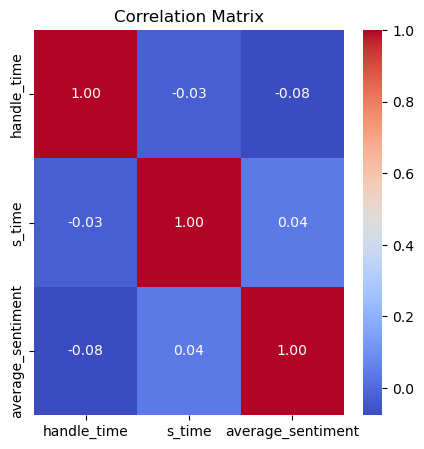

In [63]:
# First, let's calculate AHT (Average Handle Time) for each call from the 'Calls Data'
# AHT = Call End Time - Call Start Time

# Convert the relevant columns to datetime format
calls_df = dataframes['Calls Data']
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])

# Calculate handle time for each call (in minutes)
calls_df['handle_time'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds() / 60
calls_df['s_time'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds() / 60

# Merge 'Calls Data' with 'Reason' to associate each call with its reason
merged_df = pd.merge(calls_df, dataframes['Reason'], on='call_id', how='left')
merged_df['primary_call_reason'].replace(np.nan, 'unknown', inplace=True)
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].apply(clean_string)
# Calculate the average handle time (AHT) by call reason
aht_by_reason = merged_df.groupby('primary_call_reason')['handle_time'].mean().reset_index()

# Find the most and least frequent call reasons
reason_counts = merged_df['primary_call_reason'].value_counts()
most_frequent_reason = reason_counts.idxmax()
least_frequent_reason = reason_counts.idxmin()

# Get the average handle times for the most and least frequent reasons
most_frequent_aht = aht_by_reason[aht_by_reason['primary_call_reason'] == most_frequent_reason]['handle_time'].values[0]
least_frequent_aht = aht_by_reason[aht_by_reason['primary_call_reason'] == least_frequent_reason]['handle_time'].values[0]

# Calculate the percentage difference between the AHT of the most frequent and least frequent call reasons
percentage_difference = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100

# Next, we'll explore how agent performance, call types, and sentiment influence extended call durations
# Merging sentiment data with call data
merged_sentiment_df = pd.merge(merged_df, dataframes['Sentiment Statistics'], on=['call_id', 'agent_id'], how='left')
merged_sentiment_df['agent_tone'].replace(np.nan, 'unknown', inplace=True)

merged_sentiment_df['primary_call_reason'] = merged_sentiment_df['primary_call_reason'].apply(lambda x: 'postflight' if x == 'post-flight' else x)
merged_sentiment_df['primary_call_reason'] = merged_sentiment_df['primary_call_reason'].apply(lambda x: 'products&services' if x == 'productsandservices' else x)
merged_sentiment_df['primary_call_reason'] = merged_sentiment_df['primary_call_reason'].apply(lambda x: 'checkin' if x == 'check-in' else x)
merged_sentiment_df.to_csv('big_merged_sentiment_df.csv', index=False)

print(f'percentage difference between the average handling time for\nthe most frequent and least frequent call reasons: {percentage_difference:.2f}%\n')
corr_mat = merged_sentiment_df.iloc[:,3:].corr()
# plot
plt.figure(figsize=(5, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## percentage difference between the average handling time for the most frequent and least frequent call reasons: 51.21%

In [64]:
reason_counts = merged_sentiment_df['primary_call_reason'].value_counts()
reason_counts

irrops                13311
voluntarychange       10848
seating                6365
mileageplus            5851
unknown                5157
postflight             4330
communications         3840
products&services      3332
baggage                2832
upgrade                2738
booking                2637
checkin                1904
checkout               1888
voluntarycancel        1607
digitalsupport         1225
etc                     952
travelerupdates         937
othertopics             818
schedulechange          731
disability              403
unaccompaniedminor      104
Name: primary_call_reason, dtype: int64

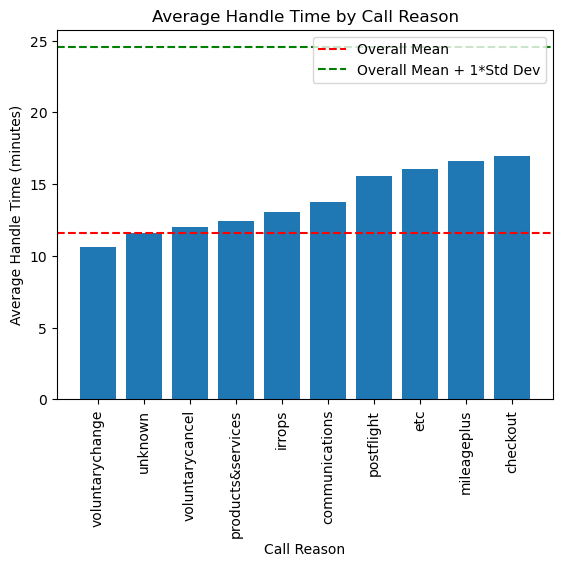

In [65]:
temp={}
for x in reason_counts.keys():
    x=str(x)
    temp[x] = merged_sentiment_df[merged_sentiment_df['primary_call_reason'] == x]['handle_time'].mean()
overall_mean = merged_sentiment_df['handle_time'].mean()
overall_std = merged_sentiment_df['handle_time'].std()
temp = dict(sorted(temp.items(), key=lambda item: item[1])[-10:])
plt.bar(temp.keys(), temp.values())
plt.axhline(y=overall_mean, color='r', linestyle='--', label='Overall Mean')
plt.axhline(y=overall_mean+overall_std, color='g', linestyle='--', label='Overall Mean + 1*Std Dev')
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (minutes)')
plt.title('Average Handle Time by Call Reason')
plt.legend()
plt.xticks(rotation=90)
plt.show()


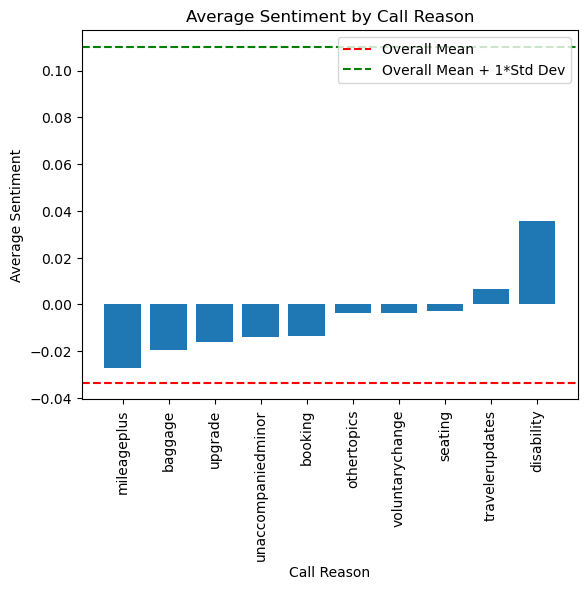

In [66]:
temp={}
for x in reason_counts.keys():
    x=str(x)
    temp[x] = merged_sentiment_df[merged_sentiment_df['primary_call_reason'] == x]['average_sentiment'].mean()
overall_mean = merged_sentiment_df['average_sentiment'].mean()
overall_std = merged_sentiment_df['average_sentiment'].std()
temp = dict(sorted(temp.items(), key=lambda item: item[1])[-10:])
plt.bar(temp.keys(), temp.values())
plt.axhline(y=overall_mean, color='r', linestyle='--', label='Overall Mean')
plt.axhline(y=overall_mean+overall_std, color='g', linestyle='--', label='Overall Mean + 1*Std Dev')
plt.xlabel('Call Reason')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Call Reason')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.show()


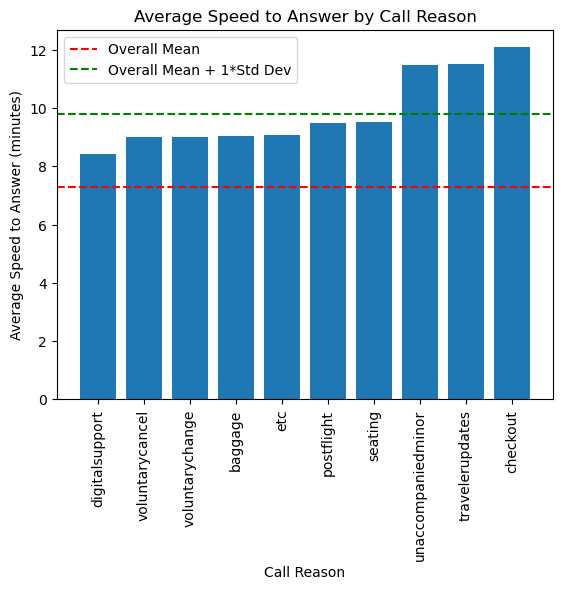

In [67]:
temp={}
for x in reason_counts.keys():
    x=str(x)
    temp[x] = merged_sentiment_df[merged_sentiment_df['primary_call_reason'] == x]['s_time'].mean()
overall_mean = merged_sentiment_df['s_time'].mean()
overall_std = merged_sentiment_df['s_time'].std()
temp = dict(sorted(temp.items(), key=lambda item: item[1])[-10:])
plt.bar(temp.keys(), temp.values())
plt.axhline(y=overall_mean, color='r', linestyle='--', label='Overall Mean')
plt.axhline(y=overall_mean+overall_std, color='g', linestyle='--', label='Overall Mean + 1*Std Dev')
plt.xlabel('Call Reason')
plt.ylabel('Average Speed to Answer (minutes)')
plt.title('Average Speed to Answer by Call Reason')
plt.legend()
plt.xticks(rotation=90)
plt.show()


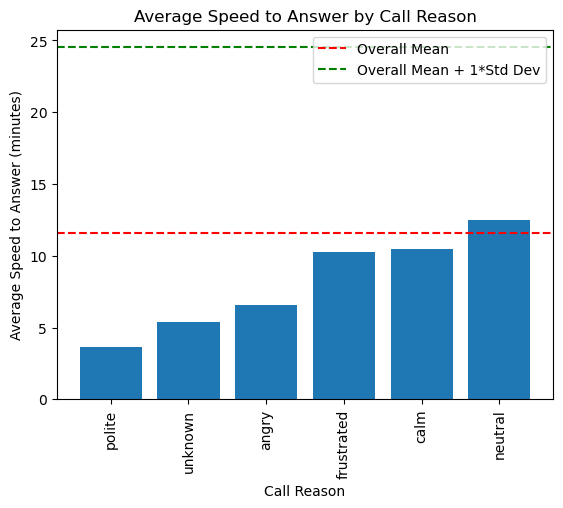

In [68]:
temp={}
for x in merged_sentiment_df['agent_tone'].value_counts().keys():
    x=str(x)
    temp[x] = merged_sentiment_df[merged_sentiment_df['agent_tone'] == x]['handle_time'].mean()
overall_mean = merged_sentiment_df['handle_time'].mean()
overall_std = merged_sentiment_df['handle_time'].std()
temp = dict(sorted(temp.items(), key=lambda item: item[1])[-10:])
plt.bar(temp.keys(), temp.values())
plt.axhline(y=overall_mean, color='r', linestyle='--', label='Overall Mean')
plt.axhline(y=overall_mean+overall_std, color='g', linestyle='--', label='Overall Mean + 1*Std Dev')
plt.xlabel('Call Reason')
plt.ylabel('Average Speed to Answer (minutes)')
plt.title('Average Speed to Answer by Call Reason')
plt.legend()
plt.xticks(rotation=90)
plt.show()

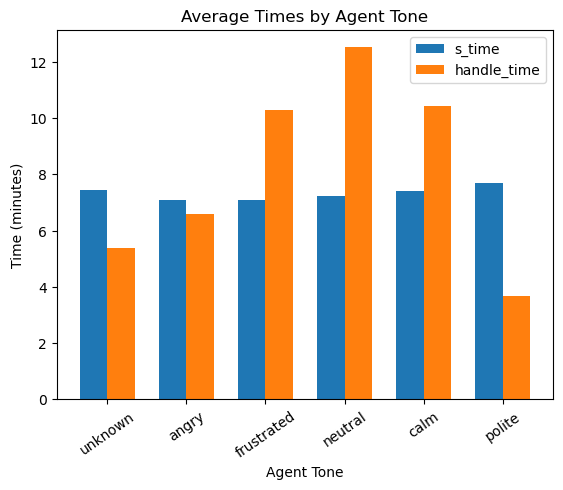

In [84]:
# Calculate mean of s_time and handle_time grouped by agent_tone
grouped_data = merged_sentiment_df.groupby('agent_tone').agg({'s_time': 'mean', 'handle_time': 'mean'})
# the order should be: unknown,angry, frustrated, neutral, calm, polite
grouped_data = grouped_data.reindex(['unknown', 'angry', 'frustrated', 'neutral', 'calm', 'polite'])

# Calculate overall mean and standard deviation for s_time
overall_mean = merged_sentiment_df['s_time'].mean()
overall_std = merged_sentiment_df['s_time'].std()

# Creating the double bar graph
fig, ax = plt.subplots()
x = np.arange(len(grouped_data)) 
width = 0.35  # the width of the bars

# Plotting bars for s_time and handle_time
rects1 = ax.bar(x - width/2, grouped_data.values[:, 0], width, label='s_time')
rects2 = ax.bar(x + width/2, grouped_data.values[:, 1], width, label='handle_time')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Agent Tone')
ax.set_ylabel('Time (minutes)')
ax.set_title('Average Times by Agent Tone')
ax.set_xticks(x)
ax.set_xticklabels(['unknown', 'angry', 'frustrated', 'neutral', 'calm', 'polite'])
plt.xticks(rotation=35)
ax.legend()

plt.show()


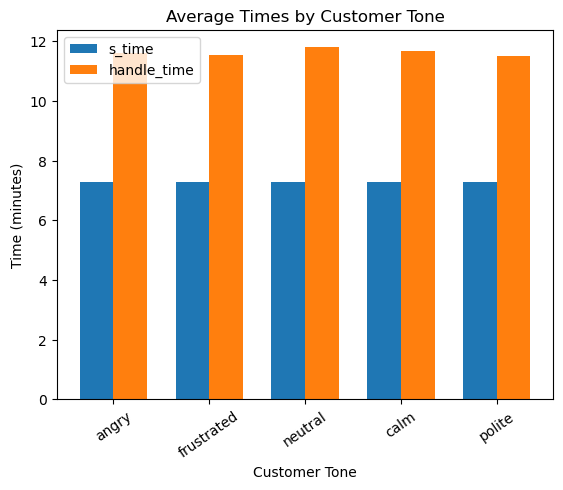

In [87]:
# Calculate mean of s_time and handle_time grouped by agent_tone
grouped_data = merged_sentiment_df.groupby('customer_tone').agg({'s_time': 'mean', 'handle_time': 'mean'})
# the order should be: unknown,angry, frustrated, neutral, calm, polite
grouped_data = grouped_data.reindex(['angry', 'frustrated', 'neutral', 'calm', 'polite'])

# Calculate overall mean and standard deviation for s_time
overall_mean = merged_sentiment_df['s_time'].mean()
overall_std = merged_sentiment_df['s_time'].std()

# Creating the double bar graph
fig, ax = plt.subplots()
x = np.arange(len(grouped_data)) 
width = 0.35  # the width of the bars

# Plotting bars for s_time and handle_time
rects1 = ax.bar(x - width/2, grouped_data.values[:, 0], width, label='s_time')
rects2 = ax.bar(x + width/2, grouped_data.values[:, 1], width, label='handle_time')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Customer Tone')
ax.set_ylabel('Time (minutes)')
ax.set_title('Average Times by Customer Tone')
ax.set_xticks(x)
ax.set_xticklabels([ 'angry', 'frustrated', 'neutral', 'calm', 'polite'])
plt.xticks(rotation=35)
ax.legend()

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


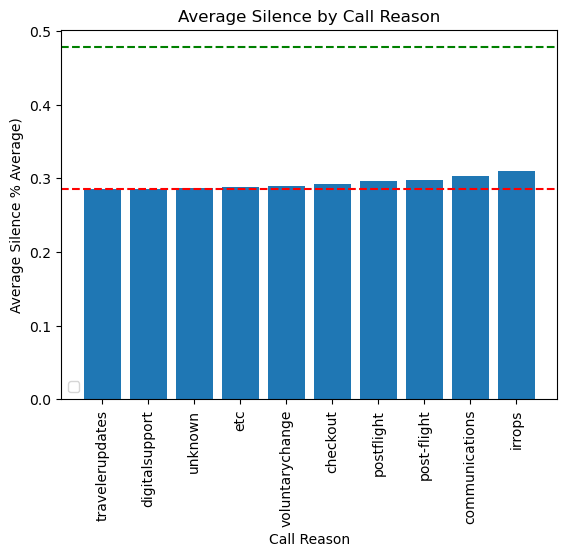

In [31]:
temp={}
for x in reason_counts.keys():
    x=str(x)
    temp[x] = merged_sentiment_df[merged_sentiment_df['primary_call_reason'] == x]['silence_percent_average'].mean()
overall_mean = merged_sentiment_df['silence_percent_average'].mean()
overall_std = merged_sentiment_df['silence_percent_average'].std()
temp = dict(sorted(temp.items(), key=lambda item: item[1])[-10:])
plt.bar(temp.keys(), temp.values())
plt.axhline(y=overall_mean, color='r', linestyle='--')
plt.axhline(y=overall_mean+overall_std, color='g', linestyle='--')
plt.xlabel('Call Reason')
plt.ylabel('Average Silence % Average)')
plt.title('Average Silence by Call Reason')
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [17]:
# add features to merged_sentiment_df

def quarter_of_day(date_time):
    hour = date_time.hour
    if hour < 6:
        return str('night')
    elif hour < 12:
        return str('morning')
    elif hour < 18:
        return str('afternoon')
    else:
        return str('evening')
    
merged_sentiment_df['quarter_of_day'] = merged_sentiment_df['call_start_datetime'].apply(quarter_of_day)



In [22]:
temp = merged_sentiment_df
X = temp[['average_sentiment','silence_percent_average','handle_time']]  # Independent variable (natural disasters)
# create dumies for agent tone and drop neutral
temp = temp.append(temp.iloc[0], ignore_index=True)
temp.at[0, 'customer_tone'] = 'neutral'
temp.at[0, 'primary_call_reason'] = 'unaccompaniedminor'
agent_tone_dummies = pd.get_dummies(temp['agent_tone'], drop_first=True)
customer_tone_dummies = pd.get_dummies(temp['customer_tone'], drop_first=True)
day_dummies = pd.get_dummies(temp['quarter_of_day'], drop_first=True)
reason_dummies = pd.get_dummies(temp['primary_call_reason'], drop_first=True)
X = pd.concat([X, agent_tone_dummies], axis=1)
X[['average_sentiment','silence_percent_average']] *= 100
X = X.iloc[1:].reset_index(drop=True)
X = sm.add_constant(X)
X.dropna(inplace=True)
y = X['handle_time']
X = X.drop('handle_time', axis=1)
# Perform panel regression using fixed effects
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of results
print(results.summary())

/var/folders/yx/4lwmhd2d1kjg0kq36qlfb5v00000gn/T/ipykernel_62371/2336252327.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp.iloc[0], ignore_index=True)


                            OLS Regression Results                            
Dep. Variable:            handle_time   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2288.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:49:05   Log-Likelihood:            -2.7790e+05
No. Observations:               71700   AIC:                         5.558e+05
Df Residuals:                   71692   BIC:                         5.559e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [10]:
def sentiment(x):
    sents = ['angry','frustrated','neutral','calm','polite']
    if x not in sents:
        return 0
    else:
        return sents.index(x)-2

merged_sentiment_df['numeric_agent_tone'] = merged_sentiment_df['agent_tone'].apply(sentiment)
merged_sentiment_df['numeric_customer_tone'] = merged_sentiment_df['customer_tone'].apply(sentiment)

temp = merged_sentiment_df
X = temp[['average_sentiment','silence_percent_average','numeric_agent_tone','handle_time']]
X[['average_sentiment','silence_percent_average']] *= 100
X = sm.add_constant(X)
X.dropna(inplace=True)

y = X['handle_time']
X = X.drop('handle_time', axis=1)

# Perform panel regression using fixed effects
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

/var/folders/yx/4lwmhd2d1kjg0kq36qlfb5v00000gn/T/ipykernel_62371/3454914807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['average_sentiment','silence_percent_average']] *= 100


                            OLS Regression Results                            
Dep. Variable:            handle_time   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5065.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:33:33   Log-Likelihood:            -2.7824e+05
No. Observations:               71701   AIC:                         5.565e+05
Df Residuals:                   71697   BIC:                         5.565e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# Busy Days

In [33]:
merged_sentiment_df['date'] = merged_sentiment_df['call_start_datetime'].dt.date
freq_dates = merged_sentiment_df['date'].value_counts()
freq_dates = freq_dates[freq_dates > np.mean(freq_dates)]

busy_df = merged_sentiment_df[merged_sentiment_df['date'].isin(freq_dates.index)]
X = busy_df[['average_sentiment','silence_percent_average','numeric_agent_tone','handle_time']]
X[['average_sentiment','silence_percent_average']] *= 100
X = sm.add_constant(X)
X.dropna(inplace=True)

y = X['handle_time']
X = X.drop('handle_time', axis=1)

# Perform panel regression using fixed effects
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            handle_time   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     3011.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:10:06   Log-Likelihood:            -1.6707e+05
No. Observations:               42984   AIC:                         3.341e+05
Df Residuals:                   42980   BIC:                         3.342e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/var/folders/yx/4lwmhd2d1kjg0kq36qlfb5v00000gn/T/ipykernel_62371/3790039044.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['average_sentiment','silence_percent_average']] *= 100


# Busy Hours

In [34]:
earliest_datetime=merged_sentiment_df['call_start_datetime'].min()
merged_sentiment_df['hour_number'] = (merged_sentiment_df['call_start_datetime'] - earliest_datetime).dt.total_seconds() // 3600

freq_dates = merged_sentiment_df['hour_number'].value_counts()
freq_dates = freq_dates[freq_dates > np.mean(freq_dates)]

busy_df = merged_sentiment_df[merged_sentiment_df['hour_number'].isin(freq_dates.index)]
X = busy_df[['average_sentiment','silence_percent_average','numeric_agent_tone','handle_time']]
X[['average_sentiment','silence_percent_average']] *= 100
X = sm.add_constant(X)
X.dropna(inplace=True)

y = X['handle_time']
X = X.drop('handle_time', axis=1)

# Perform panel regression using fixed effects
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            handle_time   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     3128.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:10:14   Log-Likelihood:            -1.7059e+05
No. Observations:               43926   AIC:                         3.412e+05
Df Residuals:                   43922   BIC:                         3.412e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/var/folders/yx/4lwmhd2d1kjg0kq36qlfb5v00000gn/T/ipykernel_62371/2948650379.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['average_sentiment','silence_percent_average']] *= 100


# Q2) IVR

In [ ]:
merged_sentiment_df = pd.read_csv('big_merged_sentiment_df.csv')
reason_counts = merged_sentiment_df['primary_call_reason'].value_counts()
reason_counts[:]

irrops                 13311
voluntarychange        10848
seating                 6365
mileageplus             5851
unknown                 5157
post-flight             3957
communications          3840
productsandservices     2856
baggage                 2832
upgrade                 2738
booking                 2637
checkout                1888
voluntarycancel         1607
check-in                1519
digitalsupport          1225
etc                      952
travelerupdates          937
othertopics              818
schedulechange           731
products&services        476
disability               403
checkin                  385
postflight               373
unaccompaniedminor       104
Name: primary_call_reason, dtype: int64

In [ ]:
top_reasons = ['mileageplus', 'irrops', 'seating', 'voluntarychange', 'baggage']
def sentence(transcript):
    try:
        arr = transcript.split("\n")
        return arr[4] + ' ' + arr[6] + ' ' + arr[8]
    except:
        return transcript

for reason in top_reasons:
    print(f"Random 5 calls for reason: {reason}")
    df = merged_sentiment_df[merged_sentiment_df['primary_call_reason'] == reason]
    df['clean_transcript'] = df['call_transcript'].apply(sentence)
    print(df['clean_transcript'].sample(5).values)
    print()

Random 5 calls for reason: mileageplus
["Customer: Yeah uh finally I got through to someone. I'm calling to complain about a flight I took with you guys last week. Agent: I apologize for any issues you experienced. Can you please provide your confirmation number so I can pull up your record? Customer: Ugh it's taking forever to find the stupid paper *sounds of rustling papers* okay, here it is, confirmation number is 4GTR562. "
 "Customer: Hi Steve, yeah I'm calling about a flight I have coming up next week. My flight number is UA113 from Chicago to LA. Agent: Okay, let me pull that flight up. *typing sounds* Yep, I've got flight UA113 here. What questions did you have about your trip? Customer: Well, I got an email saying there was a change to my flight time. The email said it was leaving an hour earlier than what it showed on my confirmation. I just wanted to double check the new departure time."
 "Agent: Yes, this is John from United Airlines customer service. How can I help you tod

In [ ]:
words = ["flight status", "delay", "cancellation", "alternative flight", "compensation" , "refund",
         "change my flight", "reschedule", "change booking", "fare difference", "seat selection", "upgrade seat", "change seat",
         "lost baggage", "track my baggage", "baggage fee", "points balance", "redeem miles", "status"]

df = pd.read_csv("data/big_merged_sentiment_df.csv")
vectorizer = TfidfVectorizer()

for word in tqdm(words):
    scores = []
    for i in range(len(df)):
        transcript = df['call_transcript'].iloc[i]
        X = vectorizer.fit_transform([transcript, word])
        score = cosine_similarity(X)
        scores.append(score[0][1])
    df[word+'_similarity_score'] = scores

df.to_csv("data/scored.csv", index=False)

100%|██████████| 19/19 [33:55<00:00, 107.12s/it]


In [ ]:
print("Key Words along with the\nnumber of related documents:\n")
for word in words:
    mn = np.mean(df[word+'_similarity_score'])
    st_dev = np.std(df[word+'_similarity_score'])
    lim = mn+st_dev
    print(word,": ",len(df[df[word+'_similarity_score'] > lim]))

Key Words along with the
number of related documents:

flight status :  11336
delay :  10409
cancellation :  6391
alternative flight :  11629
compensation :  9550
refund :  8070
change my flight :  12523
reschedule :  4520
change booking :  12582
fare difference :  10193
seat selection :  4489
upgrade seat :  5264
change seat :  12744
lost baggage :  5526
track my baggage :  10738
baggage fee :  13405
points balance :  3500
redeem miles :  4102
status :  6879


In [ ]:
for word in words:
    print(word)
    df.sort_values(by=[word+'_similarity_score'], ascending=False, inplace=True)
    print(df['call_transcript'].head(2).values)
    print()

flight status
["\n\nAgent: Thank you for calling United Airlines, my name is Sam. How may I help you today?\n\nCustomer: Hi Sam, umm...thanks for taking my call. I'm calling about a flight I have booked from Chicago to London next week. \n\nAgent: No problem, what about your flight were you looking to discuss?\n\nCustomer: Ah well, I've been reading online that there's been some delays and cancellations out of O'Hare recently because of the weather. I'm a little nervous about my flight getting impacted. Is there a chance it could get delayed or canceled? \n\nAgent: Let me take a look at your booking and get some information on the flight status. What's the date and flight number?\n\nCustomer: Sure, it's Flight 691 leaving on March 15th. \n\n*sound of typing on keyboard*\n\nAgent: Okay, I'm pulling up the information for Flight 691 on the 15th. Give me just a second here... Alright, so as of now that flight is still on schedule to depart at 11am from Chicago. The forecast for O'Hare is 